<a href="https://colab.research.google.com/github/Le-Triumvirat/CADS-Internship/blob/main/Anomaly_detection_in_financial_services_using_knowledge_graphs_and_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **<h1>Installing DGL</h1>**

In [1]:
!pip install dgl
!pip install dglke

     |████████████████████████████████| 4.4MB 15.1MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 


> # **Tutorial**

In [ ]:
import torch
import numpy as np
import dgl

# print(torch.tensor([1059,1069,1074]))
# data_ = CoraGraphDataset()
# print(data_.num_classes)
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.graph((u, v))

g=build_karate_club_graph()

In [ ]:
G = build_karate_club_graph()
print(G)
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})
We have 34 nodes.
We have 156 edges.


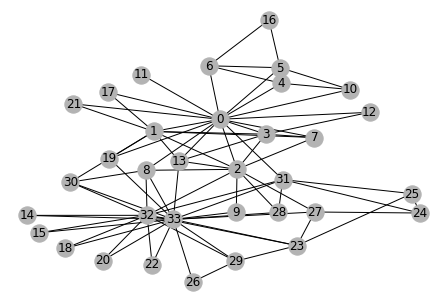

In [ ]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 1.6660,  0.4774, -0.1525,  0.8129,  0.3971], grad_fn=<SelectBackward>)
tensor([[ 0.5416, -0.4819, -1.0623, -0.1977, -0.5599],
        [-1.2774,  0.8603, -1.4466,  0.4524, -2.0403]],
       grad_fn=<IndexBackward>)


In [ ]:
from dgl.nn.pytorch import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [ ]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [ ]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6864
Epoch 1 | Loss: 0.6726
Epoch 2 | Loss: 0.6592
Epoch 3 | Loss: 0.6456
Epoch 4 | Loss: 0.6323
Epoch 5 | Loss: 0.6192
Epoch 6 | Loss: 0.6056
Epoch 7 | Loss: 0.5916
Epoch 8 | Loss: 0.5772
Epoch 9 | Loss: 0.5617
Epoch 10 | Loss: 0.5452
Epoch 11 | Loss: 0.5275
Epoch 12 | Loss: 0.5087
Epoch 13 | Loss: 0.4887
Epoch 14 | Loss: 0.4674
Epoch 15 | Loss: 0.4453
Epoch 16 | Loss: 0.4216
Epoch 17 | Loss: 0.3966
Epoch 18 | Loss: 0.3711
Epoch 19 | Loss: 0.3451
Epoch 20 | Loss: 0.3186
Epoch 21 | Loss: 0.2919
Epoch 22 | Loss: 0.2655
Epoch 23 | Loss: 0.2400
Epoch 24 | Loss: 0.2153
Epoch 25 | Loss: 0.1918
Epoch 26 | Loss: 0.1694
Epoch 27 | Loss: 0.1486
Epoch 28 | Loss: 0.1295
Epoch 29 | Loss: 0.1122
Epoch 30 | Loss: 0.0967
Epoch 31 | Loss: 0.0830
Epoch 32 | Loss: 0.0710
Epoch 33 | Loss: 0.0606
Epoch 34 | Loss: 0.0517
Epoch 35 | Loss: 0.0441
Epoch 36 | Loss: 0.0376
Epoch 37 | Loss: 0.0321
Epoch 38 | Loss: 0.0275
Epoch 39 | Loss: 0.0236
Epoch 40 | Loss: 0.0203
Epoch 41 | Loss: 0.0175
Ep

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

> # Rough work

{0: array([1.00000000e+00, 8.51494896e-09]), 1: array([0.62348981, 0.78183148]), 2: array([-0.22252091,  0.97492788]), 3: array([-0.90096878,  0.43388381]), 4: array([-0.90096878, -0.43388373]), 5: array([-0.22252097, -0.97492786]), 6: array([ 0.62348963, -0.78183159])}


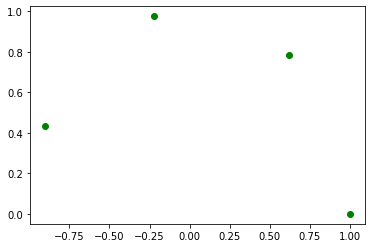

In [ ]:
G = nx.path_graph(7)
pos = nx.circular_layout(G)
print(pos)
for i in range(4):
  plt.scatter(pos[i][0],pos[i][1],color='green')

In [ ]:
import dgl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# unique nodes are 34 and edge connections are 156 (might include either directed or undirected)
def build_karate_club_graph():
    # source node
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    # destination node
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # concatenating source and destination to form connections represented as directed, as DGL by default doesn't include directed.
    u = np.concatenate([src,dst])
    v = np.concatenate([dst,src])
    return dgl.graph((u,v))

In [ ]:
g = build_karate_club_graph()
# g.ndata['features'] = torch.zeros(34,1)
# print(g)
# print(nx)
nx_g = g.to_networkx().to_undirected()
# print(type(nx_g))
# A layout function for returning coordinates of edges
pos = nx.kamada_kawai_layout(nx_g)
print(pos)

{0: array([0.02595264, 0.33261791]), 1: array([-0.15415403,  0.25105994]), 2: array([ 0.07281129, -0.00339833]), 3: array([0.15120782, 0.23250616]), 4: array([0.19313543, 0.57445429]), 5: array([0.1899636 , 0.67901702]), 6: array([-0.00442196,  0.69195753]), 7: array([0.28351952, 0.21023576]), 8: array([-0.17565775, -0.00990143]), 9: array([ 0.0706129 , -0.28925159]), 10: array([0.37980825, 0.53262302]), 11: array([-0.18776547,  0.6332519 ]), 12: array([0.43374412, 0.37950472]), 13: array([-0.0851201 ,  0.05268196]), 14: array([-0.50006702, -0.31244434]), 15: array([-0.46577851, -0.42902514]), 16: array([0.15957838, 1.        ]), 17: array([-0.279331  ,  0.51420533]), 18: array([-0.39589977, -0.53439666]), 19: array([-0.2753847 ,  0.06921985]), 20: array([-0.293375  , -0.61554259]), 21: array([-0.37319088,  0.43635094]), 22: array([-0.15864175, -0.64280203]), 23: array([ 0.23606483, -0.5155009 ]), 24: array([ 0.57008117, -0.29665386]), 25: array([ 0.54879029, -0.16639415]), 26: array([

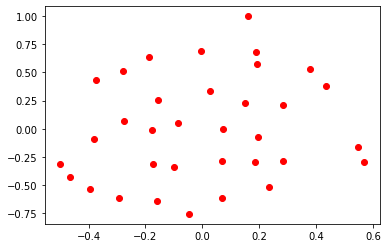

In [ ]:
for i in range(34):
  plt.scatter(pos[i][0],pos[i][1],color='red')

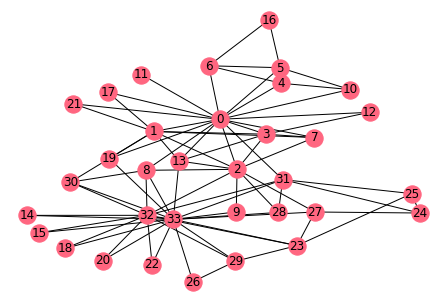

In [ ]:
nx.draw(nx_g, pos, with_labels=True, node_color=[[1,.4,.5]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# a=torch.tensor([[1,2,3],[4,5,6]])
embed = nn.Embedding(34,5)
# print(embed(a))
# print(type(embed))
# print(embed.weight)
g.ndata['feat'] = embed.weight
g.ndata['feat'][[0,1]]

tensor([[-0.7228, -1.4052,  2.0556,  0.2773,  0.7804],
        [-0.9632,  0.3832,  0.5467,  1.2536, -0.1615]],
       grad_fn=<IndexBackward>)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
net = GCN(5, 5, 2)